### This Notebooks contains lexical exploration

In [1]:
!pip install emoji
!pip install emosent-py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 KB 6.8 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234927 sha256=e7674fc17fcdeabe94fec6990c23026d07695a0412fe4f0bb399b4e69ec732db
  Stored in directory: /root/.cache/pip/wheels/f3/e3/f2/1de1c2e3ed742e1df73e0f15d58864e50c7e64f607b548d6cf
Successfully built emoji
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
  Preparing metadata (setup.py) ... done
  Created wheel for emosent-py: filename=emosent_py-0.1.6-py3-none-any.whl size=28502 sha256=b9536e0e7f8a209ff8e2b99530314b7e10164897163b270893cdc9de31c1b564
  Stored in directory: /root/.cache/pip/wheels/32/37/bd/b4e67490f36c4beb85a1047d6cd13a356ffecbfa854eaf4688
Successfully built emosent-py
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


#### Loading Libs

In [2]:
import sys
sys.path.append("../libs/leia/")
from leia import SentimentIntensityAnalyzer
import pandas as pd
import emoji
from emosent import get_emoji_sentiment_rank
from datetime import datetime

#### Loading Classifiers

In [3]:
leia_classifier = SentimentIntensityAnalyzer()

#### Custom functions

In [4]:
def remove_duplicate_emoji(orig_str):
    prev_emoji = None
    remove_duplicate_emoji = []
    try:
        for c in orig_str:
            if c in emoji.EMOJI_DATA.keys():
                if prev_emoji == c:
                    continue
                prev_emoji = c
            remove_duplicate_emoji.append(c)
        return "".join(remove_duplicate_emoji)
    except:
        return orig_str

def check_emoji_sentiment(orig_str):
    neg = 0
    neu = 0
    pos = 0
    
    try:
        emoji_list = emoji.distinct_emoji_list(orig_str)
        if len(emoji_list) > 0:
            for item in emoji_list:
                
                try:
                    sentiment_rank = get_emoji_sentiment_rank(item)
                    neg += sentiment_rank['negative']
                    neu += sentiment_rank['neutral']
                    pos += sentiment_rank['positive']
                
                except:
                    pass
        
        tot = neg + neu + pos 
        
        return {
            'neg': round(neg/tot,3),
            'neu': round(neu/tot,3),
            'pos': round(pos/tot,3)
        }
    
    except:
        return {
            'neg': round(neg,3),
            'neu': round(neu,3),
            'pos': round(pos,3)
        }

def check_text_sentiment(orig_str):
    orig_str_without_emoji =  emoji.replace_emoji(remove_duplicate_emoji(orig_str), replace='')
    sentiment_polarity = leia_classifier.polarity_scores(orig_str_without_emoji)
    
    return {
            'neg': sentiment_polarity['neg'],
            'neu': sentiment_polarity['neu'],
            'pos': sentiment_polarity['pos']
    }

def compound_sentiment(text_sentiment, emoji_sentiment):
    compound = {
        'neg': 0,
        'neu': 0,
        'pos': 0
    }
    tot = 0
    for kind in compound.keys():
        compound[kind] = text_sentiment[kind] + emoji_sentiment[kind]
        tot += compound[kind]
    return {k: round(v / tot,3) for k, v in compound.items()}

In [5]:
df_tweets = pd.read_csv('../src/application/data/tweets_brazil.csv', sep=',')

In [6]:
df_tweets.head()

,text,author_id,conversation_id,created_at,source,tweet_id,geo_id,retweet_count,reply_count,like_count,quote_count,in_reply_to_user_id,referenced_type,referenced_id
0,no gente cês parece retardado de querer saber ...,2.800738e+09,1.168307e+18,2019-09-01 23:38:37,Twitter for Android,1.168307e+18,d9d978b087a92583,0.0,1.0,3.0,0.0,NaN,NaN,NaN
1,q vírus é esse vei 🤬😡😡😡😡😡,1.010376e+18,1.168306e+18,2019-09-01 23:35:29,Twitter for Android,1.168306e+18,d9d978b087a92583,2.0,0.0,1.0,0.0,NaN,NaN,NaN
2,n posso toma duas corona q já fico feliz credo,2.969021e+09,1.168304e+18,2019-09-01 23:26:26,Twitter for Android,1.168304e+18,5722ff20ba67083b,0.0,2.0,1.0,0.0,NaN,NaN,NaN
3,era só uma corona geladinha agora poxa vida,6.329194e+07,1.168300e+18,2019-09-01 23:08:58,Twitter for Android,1.168300e+18,3b5c5c9c62f7c538,0.0,1.0,1.0,0.0,NaN,NaN,NaN
4,@SuavinBrito To bebendo corona de leve brota,1.610376e+08,1.168298e+18,2019-09-01 23:04:25,Twitter for Android,1.168299e+18,97bcdfca1a2dca59,1.0,1.0,1.0,0.0,3.431821e+09,replied_to,1.168298e+18


#### Pre-processing

Removing excessive `emojis`

In [6]:
df_tweets['text'] = df_tweets['text'].apply(lambda x: remove_duplicate_emoji(x))

Splitting sentiment between `emojis` and `text`

`emoji`

In [7]:
df_tweets['emojis_sentiment'] = df_tweets['text'].apply(
    lambda x: check_emoji_sentiment(str(x))
)

`text`

In [8]:
df_tweets['text_sentiment'] = df_tweets['text'].apply(
    lambda x: check_text_sentiment(str(x))
)

`compound`

In [9]:
df_tweets['compound'] = df_tweets.apply(
    lambda x: compound_sentiment(x['text_sentiment'], x['emojis_sentiment']), axis=1
)

#### Split data between `neutral` and `lex_on=neg/pos`

In [10]:
df_tweets['neutral'] = df_tweets.apply(
    lambda x: True if x['compound'] == {'neg': 0.0, 'neu': 1.0, 'pos': 0.0} else False, axis=1
)

Proportion

22 | INFO | generated new fontManager


<AxesSubplot:ylabel='neutral'>

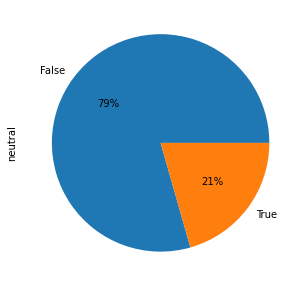

In [11]:
df_tweets.groupby(['neutral'])['neutral'].count().plot.pie(y='neutral', autopct='%1.0f%%', figsize=(5, 5))

`neutral`

In [12]:
df_neutral = df_tweets[df_tweets['neutral'] == True].reset_index(drop=True).copy()

`lex_on`

In [13]:
df_lex = df_tweets[df_tweets['neutral'] == False].reset_index(drop=True).copy()

`polarity`

In [14]:
df_lex['polarity'] = df_lex.apply(
    lambda x: "pos" if x['compound']['pos'] >= x['compound']['neg'] else "neg", axis=1
)

<AxesSubplot:ylabel='polarity'>

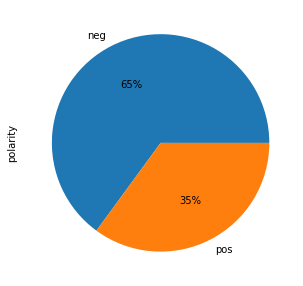

In [15]:
df_lex.groupby(['polarity'])['polarity'].count().plot.pie(y='polarity', autopct='%1.0f%%', figsize=(5, 5))

Creating `date`

In [16]:
df_lex['year'] = df_lex['created_at'].apply(
    lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S').strftime('%Y') if isinstance(x, str) else 0
)

In [17]:
df_lex['month'] = df_lex['created_at'].apply(
    lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S').strftime('%m') if isinstance(x, str) else 0
)

In [18]:
df = df_lex.groupby(['year', 'month', 'polarity'])['polarity'].agg(['count'])[1:].unstack('polarity').reset_index()

In [19]:
df.columns = ['year', 'month', 'neg', 'pos']

In [20]:
df[['neg', 'pos']] = df[['neg', 'pos']].divide(df[['neg', 'pos']].sum(axis=1), axis=0).fillna(0)[1:]

In [21]:
df = df.fillna(0)[1:]

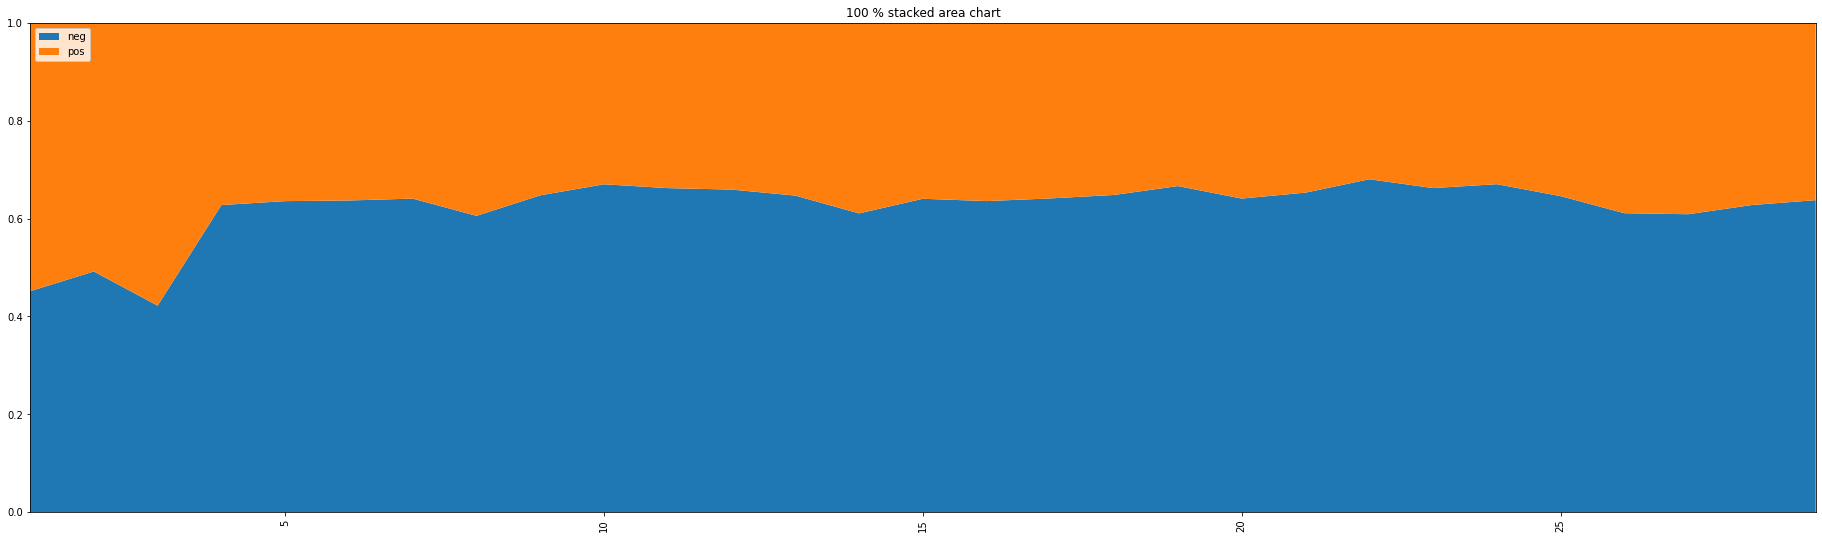

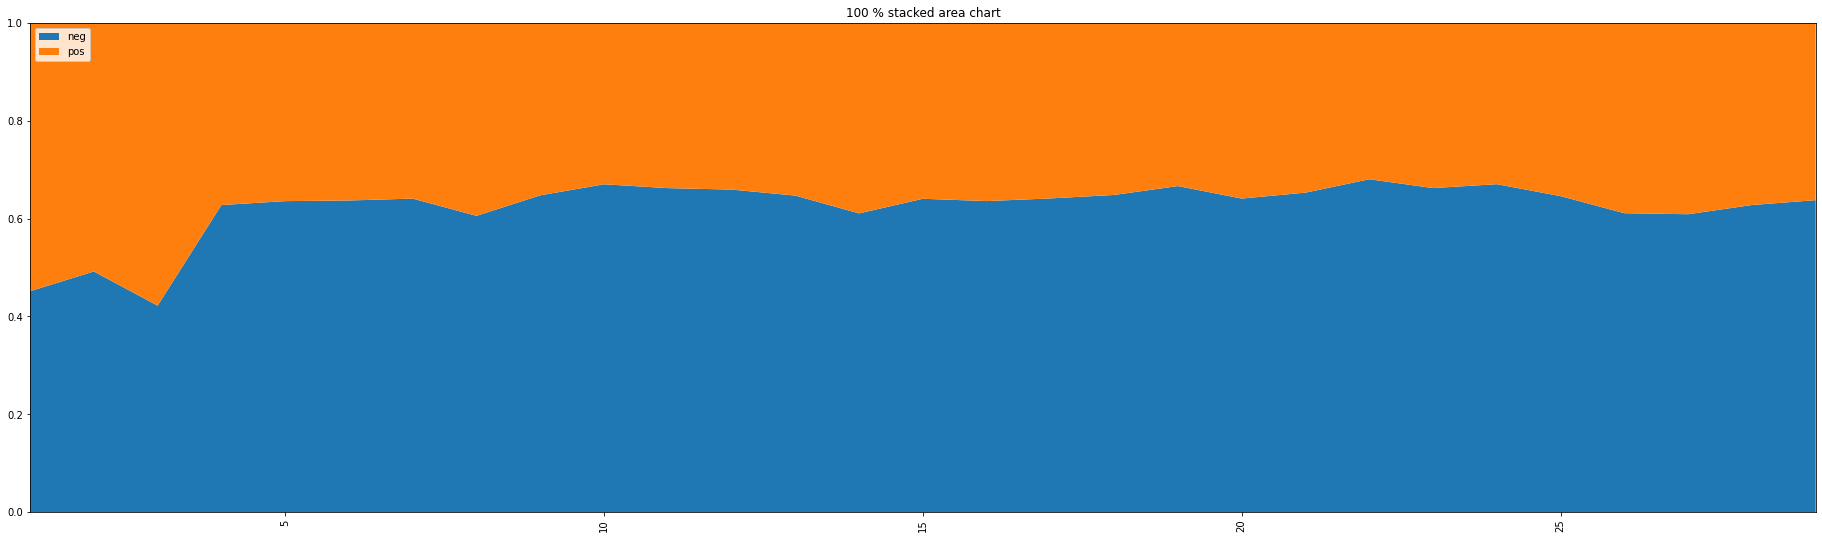

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.rcParams['figure.figsize'] = [32, 9]
plt.stackplot(df.index,  df["neg"],  df["pos"], labels=['neg','pos'])
plt.legend(loc='upper left')
plt.margins(0,0)
plt.title('100 % stacked area chart')
plt.xticks(rotation=90)
plt.show()
plt.rcParams['figure.figsize'] = [32, 9]
plt.stackplot(df.index,  df["neg"],  df["pos"], labels=['neg','pos'])
plt.legend(loc='upper left')
plt.margins(0,0)
plt.title('100 % stacked area chart')
plt.xticks(rotation=90)
plt.show()

Collecting `10`most `negative`

In [23]:
df_lex['neg_value'] = df_lex.apply(
    lambda x: x['compound']['neg'], axis=1
)

In [24]:
df_lex[['text', 'neg_value']].sort_values(by='neg_value', ascending=False)

,text,neg_value
325762,Ódio ódio ódio ódio ódio ódio ódio vírus idiota,0.970
325458,Ódio ódio ódio ódio ódio ódio ódio vírus idiota,0.970
203160,CORONA VÍRUS O MEU OVO...\n\nBLÁ BLÁ BLÁ BLÁ B...,0.932
143681,@Corona_Bot__ aí não pô :(,0.920
144019,@Corona_Bot__ aí não pô :(,0.920
...,...,...
1010958,@LiaDeSousa1 Se ele fosse teu pai o Brasil est...,0.000
1010959,Comece a semana celebrando e agradecendo. \n...,0.000
701724,"Comecei a rir no escritório só ouvi ""iiih já c...",0.000
294402,amostra grátis de foto do pé por causa do coro...,0.000


### Plots

In [25]:
df_plots = df_tweets[(df_tweets['created_at'] >= '2019-08-01') & (df_tweets['created_at'] <= '2020-05-01')]

In [26]:
df_plots['date'] = df_plots['created_at'].apply(
    lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S').strftime('%Y-%m') if isinstance(x, str) else 0
)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [27]:
df_plots['polarity'] = df_plots.apply(
    lambda x: "pos" if x['compound']['pos'] >= x['compound']['neg'] else "neg", axis=1
)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [28]:
df_plots_histo = df_plots.groupby(['date', 'polarity'])['polarity'].agg(['count'])[1:].unstack('polarity').reset_index()

In [29]:
df_plots_histo.columns = ['Data', 'Negativo', 'Positivo']

In [30]:
df_plots_histo[['Negativo', 'Positivo']] = df_plots_histo[['Negativo', 'Positivo']].divide(df_plots_histo[['Negativo', 'Positivo']].sum(axis=1), axis=0).fillna(0)[1:]

In [31]:
df_plots_histo = df_plots_histo.fillna(0)[1:]

22 | INFO | Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
22 | INFO | Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
22 | INFO | Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  # This is added back by InteractiveShellApp.init_path()


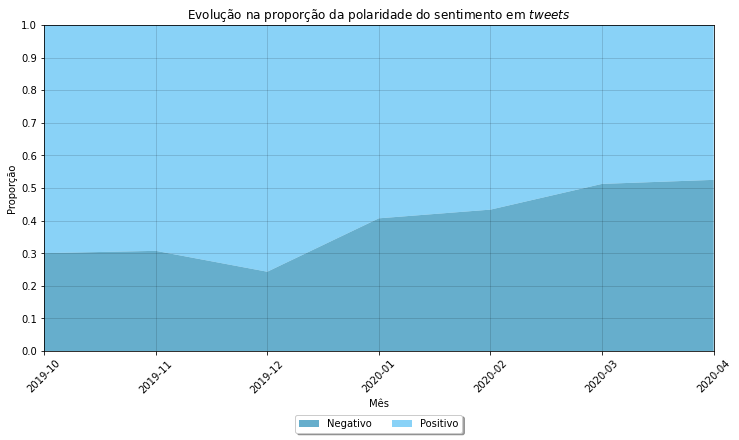

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.rcParams['figure.figsize'] = [12, 6]
plt.stackplot(df_plots_histo['Data'],  df_plots_histo["Negativo"],  df_plots_histo["Positivo"], labels=['Negativo','Positivo'],colors=['#0078AA', '#3AB4F2'], alpha=0.6)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.18), fancybox=True, shadow=True, ncol=2)
plt.margins(0,0)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(b=True, color='black', linestyle='-', alpha=0.16)
plt.title('Evolução na proporção da polaridade do sentimento em $tweets$')
plt.xlabel('Mês')
plt.ylabel('Proporção')
plt.xticks(rotation=45)
plt.show()

In [42]:
!pip install wordcloud
!pip install nltk

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [116]:
# Baixando e carregando a lista de stopwords pontuacao e pacotes de NLP
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('rslp')
from nltk.corpus import stopwords
from string import punctuation
from typing import List
import re

# Declarando o stemmer para pt
stemmer = nltk.stem.RSLPStemmer()

# Declarando as stop words customizadas
custom_stop_words = [
    'c/',
    's/',
    'p/',
    'http',
    'https',
    'link',
    'mano',
    'data',
    'cara',
    'logo',
    'viru'
]

stop_words = list(set(stopwords.words('portuguese') + list(punctuation) + custom_stop_words))

def custom_tokenizer(text_in: str,
                     min_leng: int = 3,
                     stop_words: List[str] = stop_words) -> str:
    
    text_in = " ".join(re.sub(r'[^\w]', ' ', text_in.lower()).split())
    bag: List[str] = nltk.word_tokenize(text_in)
    bag = [re.sub(r'[^\w]', ' ', word) for word in bag]
    bag = [word for word in bag if word not in stop_words if len(word) > min_leng]
    return list(set(bag))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [117]:
df_plots_wc_bef = df_plots[(df_plots['polarity'] == 'neg') &(df_plots['date'] < '2019-12')].reset_index()

In [118]:
df_plots_wc_bef['pre_text'] = df_plots_wc_bef['text'].apply(lambda x: custom_tokenizer(x))
df_plots_wc_bef['composition'] = df_plots_wc_bef['pre_text'].apply(lambda x: " ".join(x))

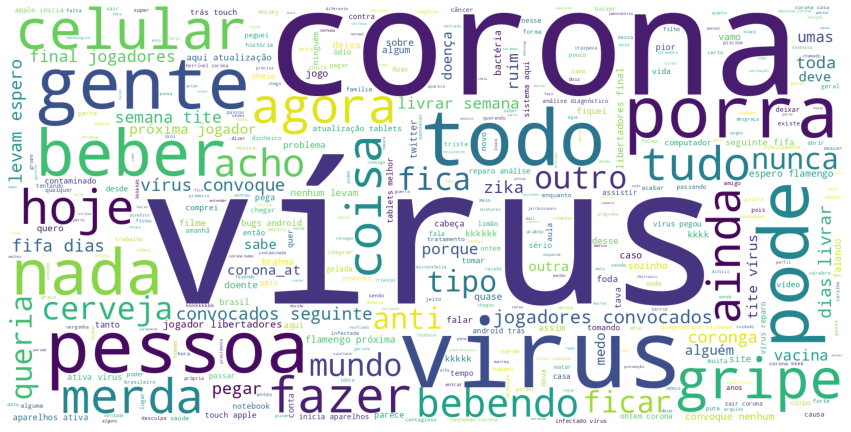

In [119]:
import re
from wordcloud import WordCloud, STOPWORDS

# Join the different processed titles together.
long_string = ','.join(list(df_plots_wc_bef['composition'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=400, contour_width=3, 
contour_color='steelblue',width=1600, height=800)# Generate a word cloud
wordcloud.generate(long_string)# Visualize the word cloud
plt.figure( figsize=(15,8) )
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [120]:
df_plots_wc_aft = df_plots[(df_plots['polarity'] == 'neg') &(df_plots['date'] > '2020-01')].reset_index()

In [121]:
df_plots_wc_aft['pre_text'] = df_plots_wc_aft['text'].apply(lambda x: custom_tokenizer(x))
df_plots_wc_aft['composition'] = df_plots_wc_aft['pre_text'].apply(lambda x: " ".join(x))
df_plots_wc_aft['composition'] = df_plots_wc_aft['composition'].fillna('')

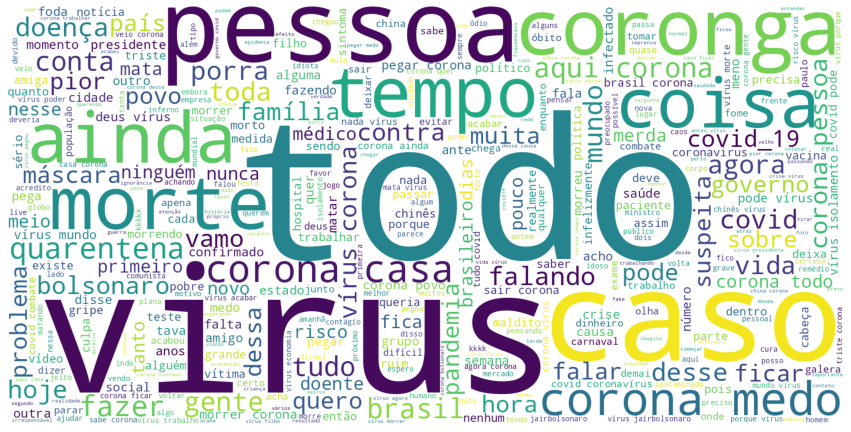

In [122]:
import re
from wordcloud import WordCloud, STOPWORDS

# Join the different processed titles together.
long_string = ','.join(list(df_plots_wc_aft['composition'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=400, contour_width=3, 
contour_color='steelblue',width=1600, height=800)# Generate a word cloud
wordcloud.generate(long_string)# Visualize the word cloud
plt.figure( figsize=(15,8) )
plt.imshow(wordcloud)
plt.axis("off")
plt.show()